In [1]:
import os
import sys
import time
import warnings

import numpy as np
from numpy.linalg import norm
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')

Parse the Data

In [2]:
from utils import *

problem = 'lra'
case = 1
study = 6

var = None
if problem != 'three_group_sphere':
    var = 'power_density'

print("Loading and formating the data...")
t_start = time.time()
if problem == 'infinite_slab':
    dataset = get_data(problem, case, study)
else:
    dataset = get_data(problem, study)
t_end = time.time()
print(f"Loading the data took {t_end - t_start:3f} s")

Loading and formating the data...
Loading the data took 110.075765 s


Setup the Truncation Study

In [5]:
from pyROMs.pod import POD

test_size = 0.2
seed = 12
interior_only = False


if problem == 'three_group_sphere':
    interp = 'rbf_gaussian' if study == 0 else 'rbf_cubic'
    epsilon = 5.0 if study == 0 else 200.0
elif problem == 'infinite_slab':
    interp = 'rbf_gaussian'
    epsilon = 10.0
elif problem == 'twigl':
    interp = 'rbf_gaussian'
    epsilon = 20.0
else:
    interp = 'rbf_gaussian'
    epsilon = 100.0

splits = dataset.train_test_split(variables=var,
                                  test_size=test_size, seed=seed,
                                  interior_only=interior_only)
X_train, X_test, Y_train, Y_test = splits

Perform the Truncation Study

In [10]:
info = {'tau': [], 'n_modes': [],
        'mean_error': [], 'max_error': [],
        'min_error': [], 'query_time': []}

taus = [10.0**i for i in range(-16, 0)]
for tau in taus:

    # Construct POD model, predict test data
    start_time = time.time()
    pod = POD(svd_rank=1.0 - tau)
    pod.fit(X_train, Y_train, interp, epsilon=epsilon)
    contruction_time = time.time() - start_time

    t_start = time.time()
    X_pred = pod.predict(Y_test)
    t_end = time.time()

    # Format datasets
    X_pred = dataset.unstack_simulation_vector(X_pred)
    X_test = dataset.unstack_simulation_vector(X_test)

    # Compute simulation errors
    errors = np.zeros(len(X_test))
    for i in range(len(X_test)):
        errors[i] = norm(X_test[i]-X_pred[i])/norm(X_test[i])

    info['tau'].append(tau)
    info['n_modes'].append(pod.n_modes)
    info['query_time'].append((t_end-t_start)/len(X_pred))
    info['mean_error'].append(np.mean(errors))
    info['max_error'].append(np.max(errors))
    info['min_error'].append(np.min(errors))

Plotting

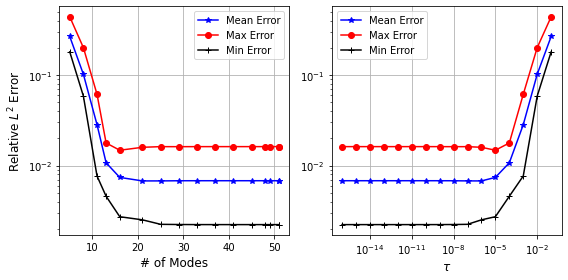

In [11]:
from typing import List
from matplotlib.pyplot import Figure, Axes

fig, axs = plt.subplots(1, 2, figsize=(8, 4))
fig: Figure = fig
axs: List[Axes] = axs.ravel()

for i, ax in enumerate(axs):
    if i == 0:
        ax.set_xlabel(f"# of Modes", fontsize=12)
        ax.set_ylabel(f"Relative $L^2$ Error", fontsize=12)
        ax.semilogy(info['n_modes'], info['mean_error'],
                    '-b*', label="Mean Error")
        ax.semilogy(info['n_modes'], info['max_error'],
                    '-ro', label="Max Error")
        ax.semilogy(info['n_modes'], info['min_error'],
                    '-k+', label="Min Error")
        ax.legend()
        ax.grid(True)
    else:
        ax.set_xlabel(f"$\\tau$", fontsize=12)
        ax.loglog(taus, info['mean_error'], '-b*', label="Mean Error")
        ax.loglog(taus, info['max_error'], '-ro', label="Max Error")
        ax.loglog(taus, info['min_error'], '-k+', label="Min Error")
        ax.legend()
        ax.grid(True)
plt.tight_layout()
plt.show()
